# `CLOUD.jl` - 2D linear advection

In [20]:
using CLOUD
using OrdinaryDiffEq
using LinearAlgebra
using TimerOutputs
plots_path = "../../ResearchDocs/ICCFD2022/"
results_path = "../results/advection_collapsed_2D/";

Define the physical problem

In [21]:
θ = π/4
a = sqrt(2)
A = 1.0  # amplitude
L = 1.0  # domain length
k = (2*π/L, 2*π/L)  # wave number
T = 1.0/(a*max(abs(cos(θ)),abs(cos(θ))))  # end time
initial_data = InitialDataSine(A,k)
conservation_law = linear_advection_equation((a*cos(θ),a*sin(θ)),λ=1.0);

Set up a collapsed DGSEM of degree `p` with `M` intervals in each direction

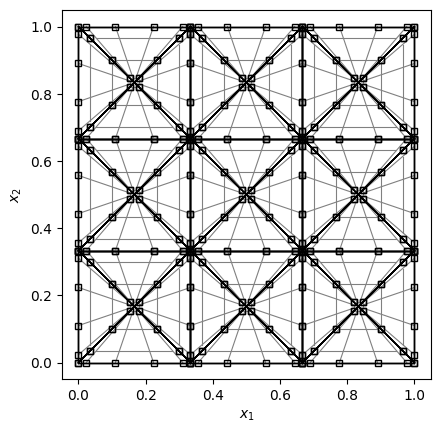

In [22]:
M = 3  # number of blocks
p = 3  # degree of discretization
reference_approximation =ReferenceApproximation(
    DGSEM(p), CollapsedTri(),
    volume_quadrature_rule=(LGQuadrature(),LGRQuadrature()),
    facet_quadrature_rule=(LGQuadrature(),LGRQuadrature()),
    N_plot=ceil(Int,50/M));
spatial_discretization = SpatialDiscretization(uniform_periodic_mesh(
    reference_approximation.reference_element, 
    ((0.0,L),(0.0,L)), (M,M), collapsed=true), reference_approximation);
results_path = save_project(conservation_law,
     spatial_discretization, initial_data, WeakConservationForm(), 
     (0.0, T), Lazy(), results_path, overwrite=true, clear=true)
visualize(spatial_discretization, plots_path, "mesh.pdf", 
    grid_lines=true, plot_volume_nodes=false, plot_facet_nodes=true)

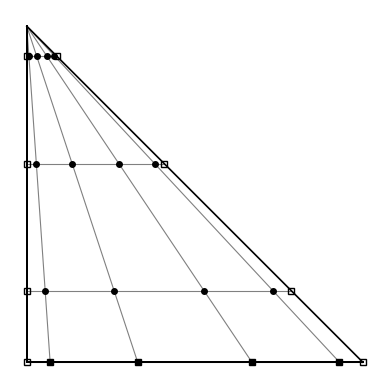

In [41]:
visualize(reference_approximation, plots_path, "ref_tri.pdf", grid_lines=true)

Run the `OrdinaryDiffEq` solver, taking `n_s` snapshots

In [23]:
reset_timer!()
n_s = 50
dt_scale=0.01
dt = dt_scale*(L/M)/(norm(a)*(2*p+1))
ode_problem = semidiscretize(load_project(results_path)...)
save_solution(ode_problem.u0, 0.0, results_path, 0)
sol = solve(ode_problem, Tsit5(), adaptive=false,
    dt=dt, save_everystep=false, krylov=:adaptive,
    callback=save_callback(results_path, ceil(Int, T/(dt*n_s))))
save_solution(last(sol.u), last(sol.t), results_path, "final")
print_timer()

 ──────────────────────────────────────────────────────────────────────────────
                                       Time                   Allocations      
                               ──────────────────────   ───────────────────────
       Tot / % measured:            10.3s / 98.8%           9.82GiB / 100%     

 Section               ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────────────────
 rhs!                   17.9k    10.2s   100%   569μs   9.81GiB  100%    576KiB
   eval residual         643k    4.51s  44.4%  7.02μs   4.38GiB  44.7%  7.14KiB
     volume terms        643k    2.02s  19.9%  3.14μs   3.33GiB  33.9%  5.42KiB
     facet terms         643k    779ms  7.66%  1.21μs    697MiB  6.94%  1.11KiB
     mass matrix solve   643k    118ms  1.16%   183ns    128MiB  1.27%     208B
   extrapolate solu...   643k    1.04s  10.2%  1.62μs   0.99GiB  10.1%  1.61KiB
   gather external ...   643k    927ms 

Visualize the solution

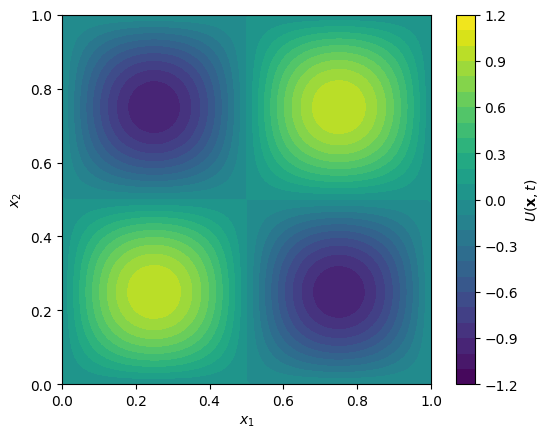

In [24]:
plotter = Plotter(spatial_discretization, plots_path)
visualize(initial_data, plotter, "exact.pdf", u_range=[-1.0,1.0], contours=25,
    label="U(\\mathbf{x},t)")

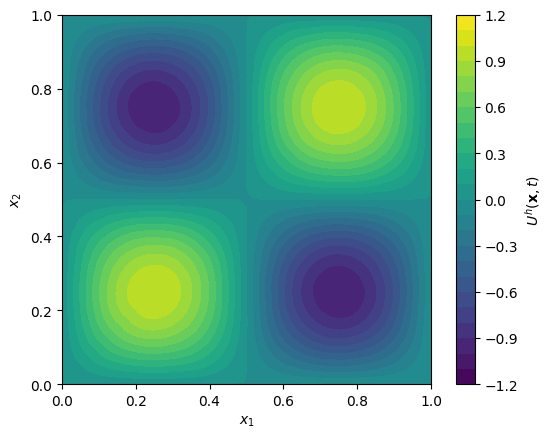

In [25]:
visualize(last(sol.u),plotter, "approx.pdf", contours=25, u_range=[-1.0,1.0],
    label="U^h(\\mathbf{x},t)")

Calculate the integral L<sup>2</sup> error norm and conservation/energy error

In [26]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
println("L2 error:\n", analyze(error_analysis, last(sol.u), initial_data))
println("Conservation (initial/final/diff):\n", analyze(conservation_analysis)...)
println("Energy (initial/final/diff):\n",analyze(energy_analysis)...)

L2 error:
[0.002543700702791563]
Conservation (initial/final/diff):
[2.6020852139652106e-17][-1.6479873021779667e-17][-4.2500725161431774e-17]
Energy (initial/final/diff):
[0.25000000000000033][0.24988047620092668][-0.00011952379907365085]


In [27]:
check_sbp_property(reference_approximation)

(3.0225821845419887e-14, 2.604687299179176e-15)